Analysis of Predictive potential of features

Added Spearman correlation analysis alongside Pearson
Created visualizations to compare Pearson vs Spearman correlations
Added a correlation heatmap using Spearman method
Added analysis to identify features that:

Appear in top 10 for both correlation methods
Have notably different rankings between methods


Added separate significance testing for both correlation types

The comparison between Pearson and Spearman correlations is particularly useful because:

Pearson measures linear relationships
Spearman measures monotonic relationships (can capture non-linear patterns)
Spearman is more robust to outliers
Differences between Pearson and Spearman can indicate non-linear relationships

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

class FeatureAnalyzer:
    def __init__(self, df):
        """Initialize with pandas DataFrame"""
        self.df = df
        self.features = self.df.drop('target', axis=1)
        self.target = self.df['target']
        
    def analyze_feature_stability(self):
        """Analyze feature stability over time"""
        stability_metrics = pd.DataFrame({
            'feature': self.features.columns,
            'std': self.features.std(),
            'coefficient_of_variation': abs(self.features.std() / self.features.mean().replace(0, np.nan)),
            'kurtosis': self.features.apply(kurtosis),
            'skewness': self.features.apply(skew)
        })
        return stability_metrics.sort_values('coefficient_of_variation')
    
    def analyze_correlations(self):
        """Analyze linear and non-linear correlations"""
        correlations = []
        for col in self.features.columns:
            pearson = stats.pearsonr(self.features[col], self.target)
            spearman = stats.spearmanr(self.features[col], self.target)
            kendall = stats.kendalltau(self.features[col], self.target)
            
            correlations.append({
                'feature': col,
                'pearson_corr': pearson[0],
                'pearson_p_value': pearson[1],
                'spearman_corr': spearman[0],
                'spearman_p_value': spearman[1],
                'kendall_corr': kendall[0],
                'kendall_p_value': kendall[1]
            })
        
        correlations = pd.DataFrame(correlations)
        correlations['abs_pearson'] = abs(correlations['pearson_corr'])
        correlations['abs_spearman'] = abs(correlations['spearman_corr'])
        correlations['abs_kendall'] = abs(correlations['kendall_corr'])
        
        return correlations
    
    def calculate_feature_importance(self):
        """Calculate feature importance using multiple methods"""
        # Random Forest importance
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(self.features, self.target)
        rf_importance = pd.DataFrame({
            'feature': self.features.columns,
            'rf_importance': rf.feature_importances_
        })
        
        # Mutual Information
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(self.features)
        mi_scores = mutual_info_regression(scaled_features, self.target)
        mi_importance = pd.DataFrame({
            'feature': self.features.columns,
            'mutual_info_score': mi_scores
        })
        
        # Combine importance scores
        importance = rf_importance.merge(mi_importance, on='feature')
        return importance.sort_values('rf_importance', ascending=False)
    
    def identify_feature_clusters(self, n_clusters=10):
        """Identify groups of similar features"""
        correlation_matrix = self.features.corr().fillna(0)  # Handle any NaN values
        clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                           affinity='precomputed', 
                                           linkage='complete')
        
        # Convert correlation matrix to distance matrix
        distance_matrix = 1 - abs(correlation_matrix)
        
        clustering.fit(distance_matrix)
        
        clusters = pd.DataFrame({
            'feature': self.features.columns,
            'cluster': clustering.labels_
        })
        return clusters
    
    def evaluate_predictive_power(self, feature, cv_folds=5):
        """Evaluate individual feature predictive power using cross-validation"""
        X = self.features[[feature]].values.reshape(-1, 1)
        scores = cross_val_score(RandomForestRegressor(n_estimators=50), 
                               X, self.target, cv=cv_folds, scoring='r2')
        return np.mean(scores)
    
    def generate_feature_recommendations(self, correlation_threshold=0.3, 
                                      importance_threshold=0.05):
        """Generate automated feature recommendations"""
        correlations = self.analyze_correlations()
        importance = self.calculate_feature_importance()
        stability = self.analyze_feature_stability()
        
        # Combine metrics
        recommendations = correlations.merge(importance, on='feature')
        recommendations = recommendations.merge(stability, on='feature')
        
        # Classify features
        recommendations['recommendation'] = 'neutral'
        
        # Strong predictors
        strong_predictors = recommendations[
            (recommendations['abs_pearson'] > correlation_threshold) & 
            (recommendations['rf_importance'] > importance_threshold)
        ]
        recommendations.loc[strong_predictors.index, 'recommendation'] = 'strong_predictor'
        
        # Unstable features
        unstable_features = recommendations[
            recommendations['coefficient_of_variation'] > recommendations['coefficient_of_variation'].quantile(0.9)
        ]
        recommendations.loc[unstable_features.index, 'recommendation'] = 'unstable'
        
        return recommendations
    
    def plot_analysis(self):
        """Generate comprehensive visualization of the analysis"""
        correlations = self.analyze_correlations()
        importance = self.calculate_feature_importance()
        
        # Create figure
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        
        # Plot 1: Feature Importance Comparison
        axes[0, 0].scatter(importance['rf_importance'], importance['mutual_info_score'], alpha=0.5)
        axes[0, 0].set_xlabel('Random Forest Importance')
        axes[0, 0].set_ylabel('Mutual Information Score')
        axes[0, 0].set_title('Feature Importance Comparison')
        
        # Plot 2: Correlation Methods Comparison
        axes[0, 1].scatter(correlations['pearson_corr'], correlations['spearman_corr'], alpha=0.5)
        axes[0, 1].set_xlabel('Pearson Correlation')
        axes[0, 1].set_ylabel('Spearman Correlation')
        axes[0, 1].set_title('Linear vs Rank Correlation')
        axes[0, 1].axline([0, 0], [1, 1], color='r', linestyle='--', alpha=0.3)
        
        # Plot 3: Feature Stability
        stability = self.analyze_feature_stability()
        axes[1, 0].scatter(stability['coefficient_of_variation'], stability['kurtosis'], alpha=0.5)
        axes[1, 0].set_xlabel('Coefficient of Variation')
        axes[1, 0].set_ylabel('Kurtosis')
        axes[1, 0].set_title('Feature Stability Analysis')
        
        # Plot 4: Feature Clustering Dendrogram
        correlation_matrix = self.features.corr().fillna(0)
        linkage_matrix = linkage(1 - abs(correlation_matrix), 'ward')
        dendrogram(linkage_matrix, labels=self.features.columns, leaf_rotation=90, ax=axes[1, 1])
        axes[1, 1].set_title('Feature Clustering Dendrogram')
        
        plt.tight_layout()
        return fig

def analyze_dataset(file_path):
    """Main function to analyze the dataset"""
    # Read the data, skipping the "sample dataset" line if it exists
    df = pd.read_csv(file_path, parse_dates=['Open time'])
    df.set_index('Open time', inplace=True)
    
    # Initialize analyzer
    analyzer = FeatureAnalyzer(df)
    
    # Generate comprehensive analysis
    correlations = analyzer.analyze_correlations()
    importance = analyzer.calculate_feature_importance()
    stability = analyzer.analyze_feature_stability()
    clusters = analyzer.identify_feature_clusters()
    recommendations = analyzer.generate_feature_recommendations()
    
    # Create visualization
    fig = analyzer.plot_analysis()
    plt.show()  # This line is important!
    
    print("\n=== Analysis Summary ===")
    print(f"Total features analyzed: {len(analyzer.features.columns)}")
    
    # Top features by different metrics
    print("\n=== Top 5 Features by Different Metrics ===")
    print("\nRandom Forest Importance:")
    print(importance.head()[['feature', 'rf_importance']])
    
    print("\nMutual Information Score:")
    print(importance.sort_values('mutual_info_score', ascending=False).head()[['feature', 'mutual_info_score']])
    
    print("\nAbsolute Pearson Correlation:")
    print(correlations.sort_values('abs_pearson', ascending=False).head()[['feature', 'pearson_corr']])
    
    # Feature recommendations
    strong_predictors = recommendations[recommendations['recommendation'] == 'strong_predictor']
    print(f"\nNumber of strong predictors identified: {len(strong_predictors)}")
    if not strong_predictors.empty:
        print("\nTop strong predictors:")
        print(strong_predictors[['feature', 'pearson_corr', 'rf_importance']].head())
    
    return {
        'correlations': correlations,
        'importance': importance,
        'stability': stability,
        'clusters': clusters,
        'recommendations': recommendations,
        'figure': fig
    }

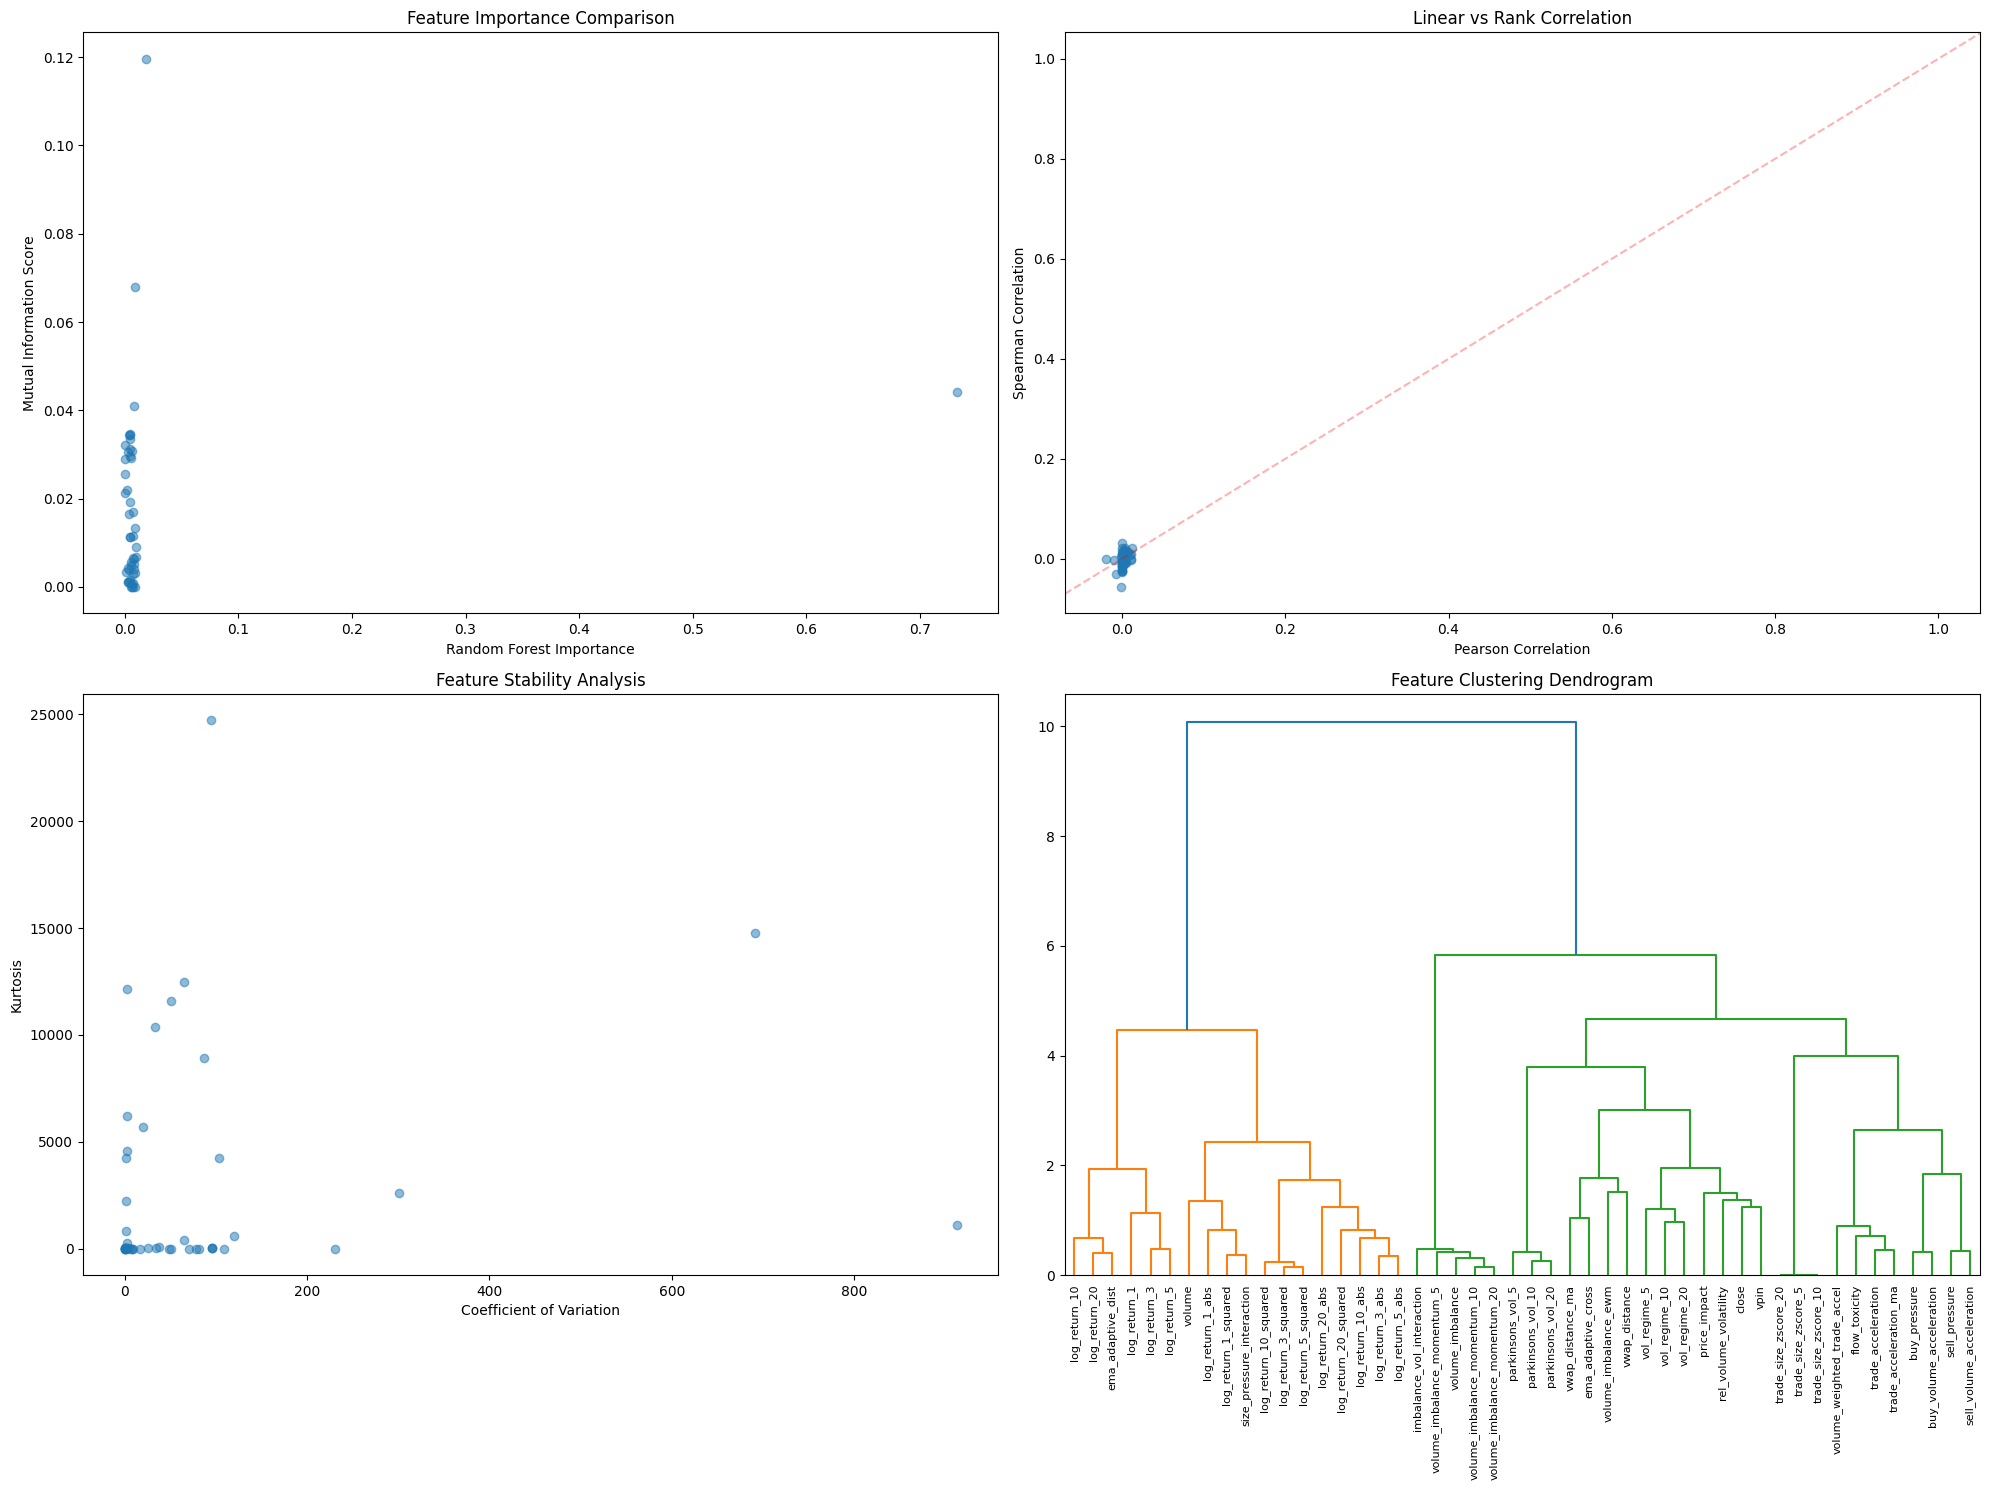


=== Analysis Summary ===
Total features analyzed: 48

=== Top 5 Features by Different Metrics ===

Random Forest Importance:
                  feature  rf_importance
33      parkinsons_vol_20       0.732408
31      parkinsons_vol_10       0.018694
43  rel_volume_volatility       0.009917
34          vol_regime_20       0.009804
32          vol_regime_10       0.009431

Mutual Information Score:
              feature  mutual_info_score
31  parkinsons_vol_10           0.119517
0               close           0.062954
33  parkinsons_vol_20           0.044515
29   parkinsons_vol_5           0.041015
8        log_return_5           0.035920

Absolute Pearson Correlation:
              feature  pearson_corr
40               vpin     -0.019126
32      vol_regime_10      0.012474
33  parkinsons_vol_20      0.010996
31  parkinsons_vol_10      0.010698
34      vol_regime_20      0.010634

Number of strong predictors identified: 0

Top 10 features by Random Forest importance:
                  f

In [6]:
CSV_FILE = "features_dataset.csv"
results = analyze_dataset(CSV_FILE)

# Access different components of the analysis
correlations = results['correlations']
importance = results['importance']
recommendations = results['recommendations']

# Get top 10 most important features according to different metrics
print("\nTop 10 features by Random Forest importance:")
print(results['importance'].head(10))

print("\nTop 10 features by Pearson correlation:")
print(results['correlations'].sort_values('abs_pearson', ascending=False).head(10))

print("\nRecommended features for prediction:")
print(results['recommendations'][results['recommendations']['recommendation'] == 'strong_predictor'])